In [1]:
from pea.mail_util import Emails

email_obj = Emails()

In [2]:
# Remove tool decorator to run
# email_obj.get_mails_content(from_addr="noreply@redditmail.com")

In [3]:
# Remove tool decorator to run
# email_obj.get_mails_content(filter="SEEN", from_addr="noreply@redditmail.com")

In [6]:
from pea.mail_util import get_mails_content_tool
print(get_mails_content_tool.args)

{'filter': {'description': 'Filter on mails supported by IMAPClient like UNSEEN', 'title': 'Filter', 'type': 'string'}, 'from_addr': {'description': "Sender's email address", 'title': 'From Addr', 'type': 'string'}}


In [23]:
from langgraph.prebuilt import ToolNode, tools_condition

tools = [get_mails_content_tool]

tool_node = ToolNode(tools)

In [24]:
from langchain_ollama import ChatOllama
llm = ChatOllama(model="mistral", temperature=0).bind_tools(tools)

In [50]:
from langgraph.graph import END, StateGraph, MessagesState
from typing import Annotated, Literal, TypedDict

# Define the function that calls the model
def get_mails(state: MessagesState):
    messages = state['messages']
    response = llm.invoke(messages)
    print(response)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

def summarise(state: MessagesState):
    static_prompt = "You are a personalised mail assistant. Given the below mails, your job is to summarise them each in not more than 2 sentences and output them in order. Make sure for each summary, you provide from, date, subject and the final summary of that mail. The output must be in the format {'from': <from>, 'subject': <subj>, 'datetime': <datetime>, 'summary': <summary>}"
    messages = state['messages']
    print(messages)
    response = llm.invoke(static_prompt + str(messages))
    return {"messages": [response]}

In [51]:
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import MemorySaver

# Define a new graph
workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("get_mails", get_mails)
workflow.add_node("summarise", summarise)
workflow.add_node("tools", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("get_mails")
workflow.add_conditional_edges(
    "get_mails",
    tools_condition,
)
workflow.add_edge("tools", 'get_mails')

workflow.add_edge("get_mails", 'summarise')


workflow.add_edge("summarise", END)

# Initialize memory to persist state between graph runs
checkpointer = MemorySaver()

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable.
# Note that we're (optionally) passing the memory when compiling the graph
app = workflow.compile(checkpointer=checkpointer)


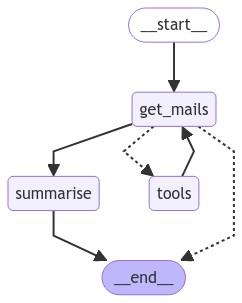

In [52]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [53]:
#  Use the Runnable
final_state = app.invoke(
    {"messages": [HumanMessage(content="unseen mails from noreply@redditmail.com")]},
    config={"configurable": {"thread_id": 42}}
)
final_state["messages"][-1].content


content='' response_metadata={'model': 'mistral', 'created_at': '2024-08-21T18:56:12.782640949Z', 'message': {'role': 'assistant', 'content': '', 'tool_calls': [{'function': {'name': 'get_mails_content', 'arguments': {'filter': 'UNSEEN', 'from_addr': 'noreply@redditmail.com'}}}]}, 'done_reason': 'stop', 'done': True, 'total_duration': 17586900806, 'load_duration': 7357916486, 'prompt_eval_count': 335, 'prompt_eval_duration': 4716658000, 'eval_count': 37, 'eval_duration': 5462022000} id='run-0d8d0ba4-c506-4648-a720-3c49f78db13e-0' tool_calls=[{'name': 'get_mails_content', 'args': {'filter': 'UNSEEN', 'from_addr': 'noreply@redditmail.com'}, 'id': '7e17415f-bc45-404c-8b1c-eab76e132bb8', 'type': 'tool_call'}] usage_metadata={'input_tokens': 335, 'output_tokens': 37, 'total_tokens': 372}
[HumanMessage(content='unseen mails from noreply@redditmail.com', id='529aea27-d54f-4bdc-8d4d-7dee49962d85'), AIMessage(content='', response_metadata={'model': 'mistral', 'created_at': '2024-08-21T18:56:12.

"1. The Reddit posts and notifications you provided are from various subreddits:\n     - r/OMSA: A post asking for stories from non-traditional background students.\n     - r/OMSCS: A post sharing free and discounted resources for OMSCS students, with a link to a website.\n     - r/LocalLLaMA: Announcement of the release of Phi-3.5, a lightweight, state-of-the-art open model built upon datasets used for Phi-3. A link to the Hugging Face page is provided.\n     - r/learnmachinelearning: A question asking about less-known ML applications that are not often shown in the media.\n     - r/gatech: A post from a student who is taking up a part-time job while being a full-time student and seeking advice on managing their schedule, especially during recruitment season. They also list the classes they're taking (CS 2110 - computer architecture).\n\n  2. The notification is a daily digest for r/OMSA, r/OMSCS, r/LocalLLaMA, r/learnmachinelearning, and r/gatech. It includes posts from each subreddi

In [54]:
print(final_state["messages"][-1].content)

1. The Reddit posts and notifications you provided are from various subreddits:
     - r/OMSA: A post asking for stories from non-traditional background students.
     - r/OMSCS: A post sharing free and discounted resources for OMSCS students, with a link to a website.
     - r/LocalLLaMA: Announcement of the release of Phi-3.5, a lightweight, state-of-the-art open model built upon datasets used for Phi-3. A link to the Hugging Face page is provided.
     - r/learnmachinelearning: A question asking about less-known ML applications that are not often shown in the media.
     - r/gatech: A post from a student who is taking up a part-time job while being a full-time student and seeking advice on managing their schedule, especially during recruitment season. They also list the classes they're taking (CS 2110 - computer architecture).

  2. The notification is a daily digest for r/OMSA, r/OMSCS, r/LocalLLaMA, r/learnmachinelearning, and r/gatech. It includes posts from each subreddit, with 

In [30]:
s = "Summarise the below mails one by one and output them in order."
t = '1. Email:\n     From: Reddit <noreply@redditmail.com>\n     Subject: "Anyone here from a non-traditional backgroun..."\n     Date/Time: August 21, 2024 16:35:44 UTC\n     Body: Reddit\n     r/OMSA: Anyone here from a non-traditional background? I\'m interested to hear other\'s journery! I graduated as a nurse in 2019 and worked through covid until end of 2022 where I picked up some skills in SQL and Excel, and landed my first analytics job in ...\n     r/OMSA\n     r/OMSCS: Free and Discounted Stuff and Resources for OMSCS students. What the title says, I moved my list of links to a website so as not to run afoul of the unwritten rule about not using too many links. If it\'s a written rule I cannot find it here or in r/help.\n     [Link] (https://...)\n     r/LocalLLaMA: Phi-3.5 has been released\n     [Link] (https://huggingface.co/microsoft/Phi-3.5-mini-instruct) (3.8B)\n     Phi-3.5 mini is a lightweight, state-of-the-art open model built upon datasets used for Phi-3 - synthetic data and real-world data from the internet.\n     r/learnmachinelearning: What are some crazy or awesome ML applications that are less shown in the media?\n     r/gatech: I\'m taking up a part one job while also being a full time student this semester and now I\'m lost. Im lost on what to do this semester. Im a CS major and going into my third year. Of course, recruitment season also comes with the Fall semester.\n     The classes I\'m taking are\n     CS 2110 - computer architecture\n     ...\n\n  2. Notification:\n     From: Reddit <noreply@redditmail.com>\n     Subject: Daily Digest for r/OMSA, r/OMSCS, r/LocalLLaMA, r/learnmachinelearning, and r/gatech\n     Body: Here\'s your daily digest for r/OMSA, r/OMSCS, r/LocalLLaMA, r/learnmachinelearning, and r/gatech. To unsubscribe from these emails or to manage what Reddit sends you, visit your settings.\n     1. r/OMSA: Anyone here from a non-traditional background? I\'m interested to hear other\'s journery! I graduated as a nurse in 2019 and worked through covid until end of 2022 where I picked up some skills in SQL and Excel, and landed my first analytics job in ...\n     2. r/OMSCS: Free and Discounted Stuff and Resources for OMSCS students. What the title says, I moved my list of links to a website so as not to run afoul of the unwritten rule about not using too many links. If it\'s a written rule I cannot find it here or in r/help.\n     3. [Link] (https://...)\n     4. r/LocalLLaMA: Phi-3.5 has been released\n     5. [Link] (https://huggingface.co/microsoft/Phi-3.5-mini-instruct) (3.8B)\n     6. Phi-3.5 mini is a lightweight, state-of-the-art open model built upon datasets used for Phi-3 - synthetic data and real-world data from the internet.\n     7. r/learnmachinelearning: What are some crazy or awesome ML applications that are less shown in the media?\n     8. r/gatech: I\'m taking up a part one job while also being a full time student this semester and now I\'m lost. Im lost on what to do this semester. Im a CS major and going into my third year. Of course, recruitment season also comes with the Fall semester.\n     9. The classes I\'m taking are\n     CS 2110 - computer architecture\n'
llm.invoke(s+t)

AIMessage(content="1. Summary: A user from Reddit is seeking advice on their journey as a non-traditional student in the field of analytics. They have recently landed their first job and are interested in hearing about others' experiences. Additionally, they shared links to resources for OMSCS students and information about the release of Phi-3.5, a lightweight open model built upon datasets used for Phi-3.\n\n  2. Summary: This is a notification from Reddit containing a daily digest of posts from various subreddits (OMSA, OMSCS, LocalLLaMA, learnmachinelearning, and gatech). The digest includes links to posts about resources for OMSCS students, the release of Phi-3.5, a discussion on less-known ML applications, and a post from a CS student at Georgia Tech seeking advice on managing their coursework while also working part-time.", response_metadata={'model': 'mistral', 'created_at': '2024-08-21T18:19:38.019884524Z', 'message': {'role': 'assistant', 'content': "1. Summary: A user from R